In [1]:
import numpy as np
import pandas as pd
import os
import json
from matplotlib import pyplot as plt
import seaborn as sns
import pickle

In [2]:
RUN_PATH = '/mnt/ssd-1/sai/semantic-memorization/experiments/'

In [6]:
baseline_path = os.path.join(RUN_PATH, 'run-d6-0-50', 'deduped', '12b')

In [4]:
with open(os.path.join(baseline_path, 'lr.pkl'), 'rb') as f:
    baseline_model = pickle.load(f)

In [5]:
baseline_model.feature_names_in_

array(['sequence_duplicates', 'max_frequency', 'avg_frequency',
       'min_frequency', 'median_frequency', 'p25_frequency',
       'p75_frequency', 'generation_perplexity', 'prompt_perplexity',
       'sequence_perplexity', '0_8_templates', '0_8_snowclones',
       'huffman_coding_length', 'is_templating'], dtype=object)

In [72]:
with open(os.path.join(baseline_path, 'recitation_lr.pkl'), 'rb') as f:
    recitation_model = pickle.load(f)

In [28]:
recitation_model.coef_

array([[ 0.28921271,  1.14851481, -0.77756428, -0.88460932,  0.43489322,
         0.06486117,  2.26751414, -2.30037168, -1.39302515, -0.83287386,
         3.05065404,  3.55787401, -2.3651891 ,  3.21166625]])

In [15]:
baseline_taxonomies_path = os.path.join(baseline_path, 'model_taxonomy', "taxonomic_prediction_metrics.json")
with open(baseline_taxonomies_path, 'r') as f:
    data = json.load(f)
    
base_evals = {
    'taxonomy': [],
    'metric': [],
    'value': [],
    'model': [],
}

for key, value in data.items():
    if key.endswith('pr_curve'):
        continue
    model, taxonomy, metric, _ = key.split("_")
    if model == 'model':
        model = 'taxonomic_model'
    base_evals['taxonomy'].append(taxonomy)
    base_evals['metric'].append(metric)
    base_evals['value'].append(value)
    base_evals['model'].append(model)
base_evals_pd = pd.DataFrame.from_dict(base_evals)

In [16]:
precision, recall, thresholds = data['model_recitation_pr_curve']

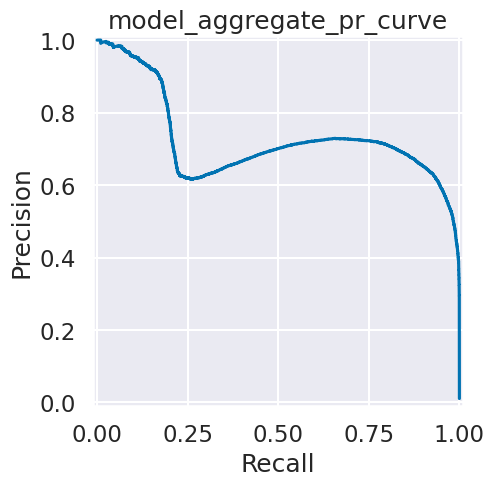

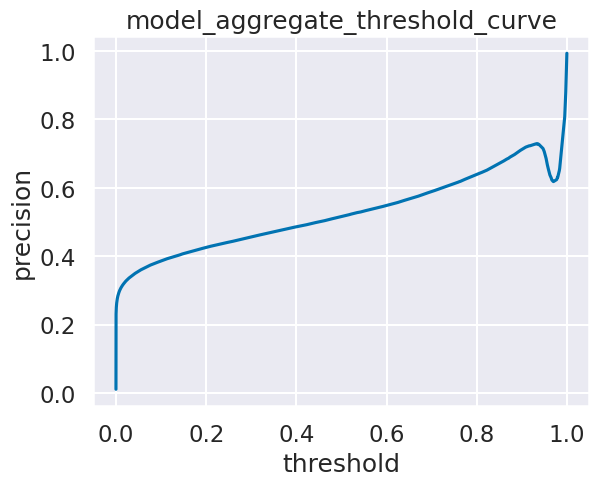

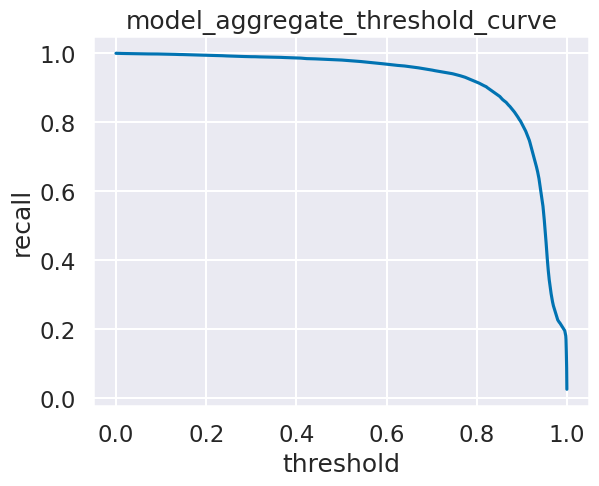

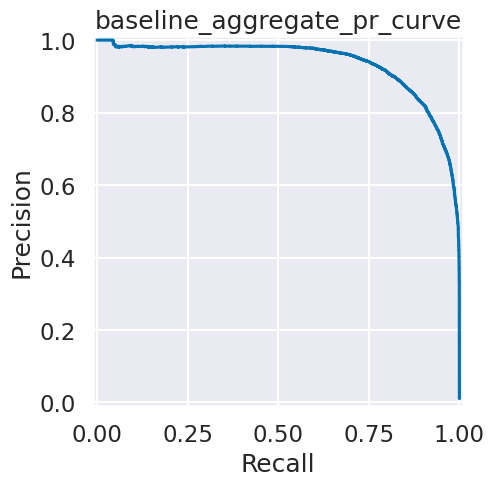

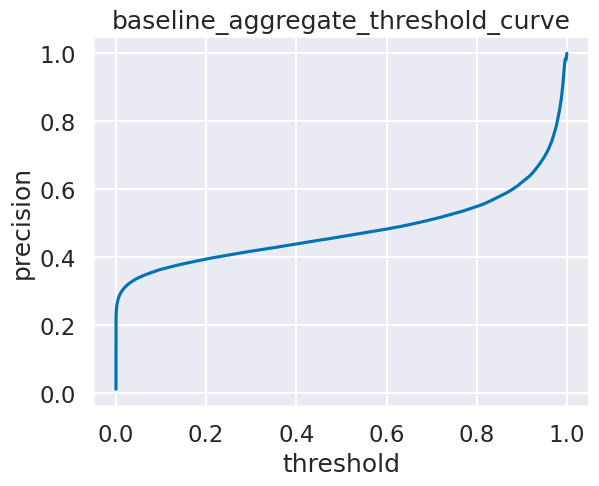

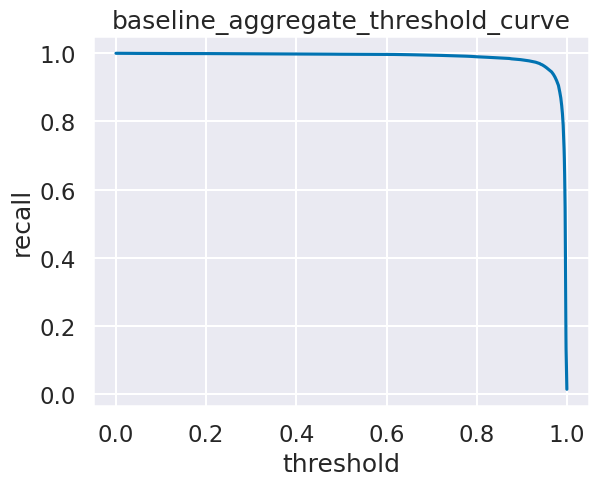

In [17]:
sns.set_theme(style="darkgrid")
sns.set_palette("colorblind")
sns.set_context("talk")
from pprint import pprint
from sklearn.metrics import PrecisionRecallDisplay
def plot_pr_curve(precision, recall, threshold, title=""):
    ax = sns.lineplot(x=threshold, y=precision)
    plt.title(title + '_threshold_curve')
    plt.xlabel('threshold')
    plt.ylabel('precision')
    plt.show()
    ax = sns.lineplot(x=threshold, y=recall)
    plt.title(title + '_threshold_curve')
    plt.xlabel('threshold')
    plt.ylabel('recall')
    plt.show()

for m_type in ['model', 'baseline']:
    for tax in ['aggregate']:
        precision, recall, thresholds = data[f'{m_type}_{tax}_pr_curve']
        precision = np.array(precision)
        recall = np.array(recall)
        thresholds = np.array(thresholds + [1])
        disp = PrecisionRecallDisplay(precision, recall)
        disp.plot()
        plt.title(f"{m_type}_{tax}_pr_curve")
        plt.show()
        random_indicies = np.random.randint(0, len(precision), size=5000)
        random_indicies.sort()
        precision = precision[random_indicies]
        recall = recall[random_indicies]
        thresholds = thresholds[random_indicies]
        plot_pr_curve(precision, recall, thresholds, f"{m_type}_{tax}")

In [18]:
sns.set_theme(style="darkgrid")
sns.set_palette("colorblind")
sns.set_context("talk")
metric_lims = {
    'roc_auc': (0.8, 1),
    'pr_auc': (0, 1),
    'precision': (0, 1),
    'recall': (0.9, 1)
}
def plot_taxonomy(taxonomy_evals, title=""):
    for metric in taxonomy_evals['metric'].unique():
        evals = taxonomy_evals[taxonomy_evals['metric'] == metric]
        ax = sns.barplot(evals, y='taxonomy', x='value', hue='model')
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
        plt.xlabel('area_under_curve')
        plt.ylabel('taxonomy')
        if metric in ['roc', 'pr']:
            metric += '_auc'
        plt.title(title + f"{metric} evals")
        plt.xlim(metric_lims[metric])
        plt.show()

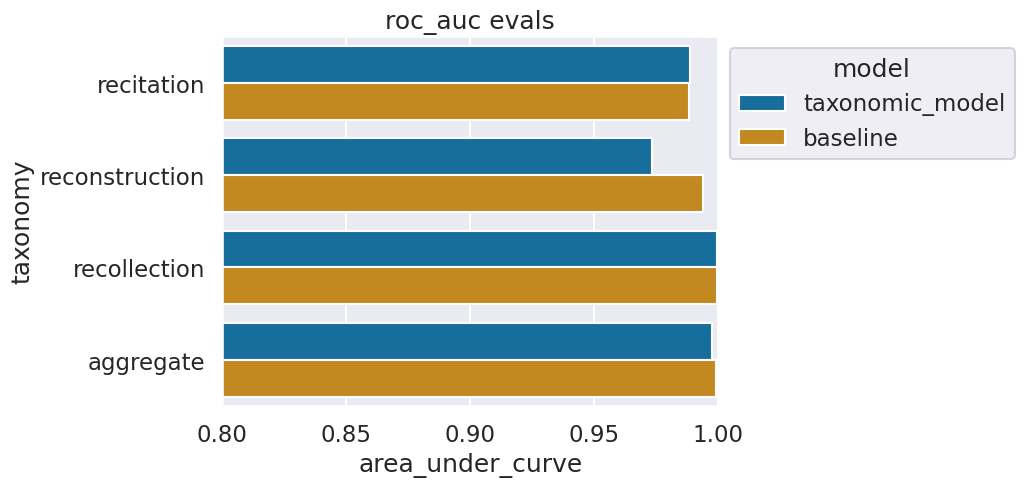

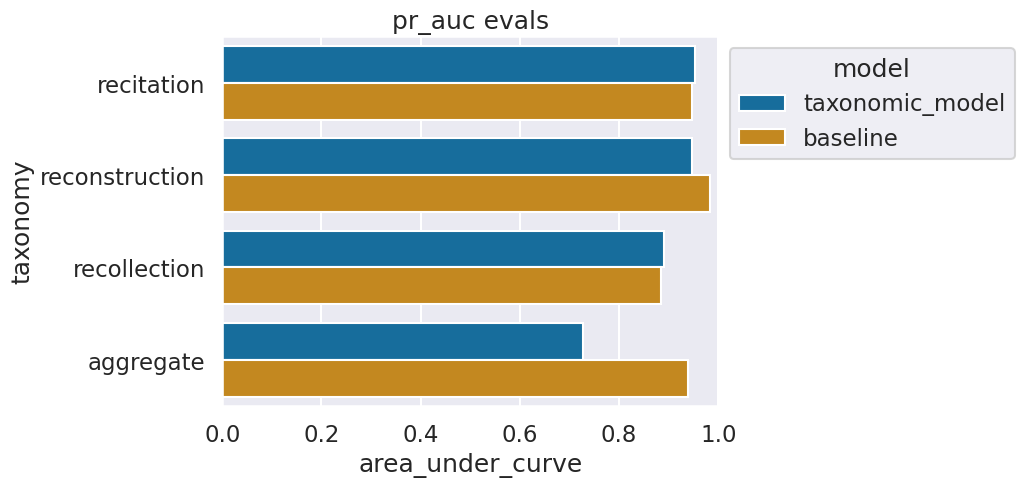

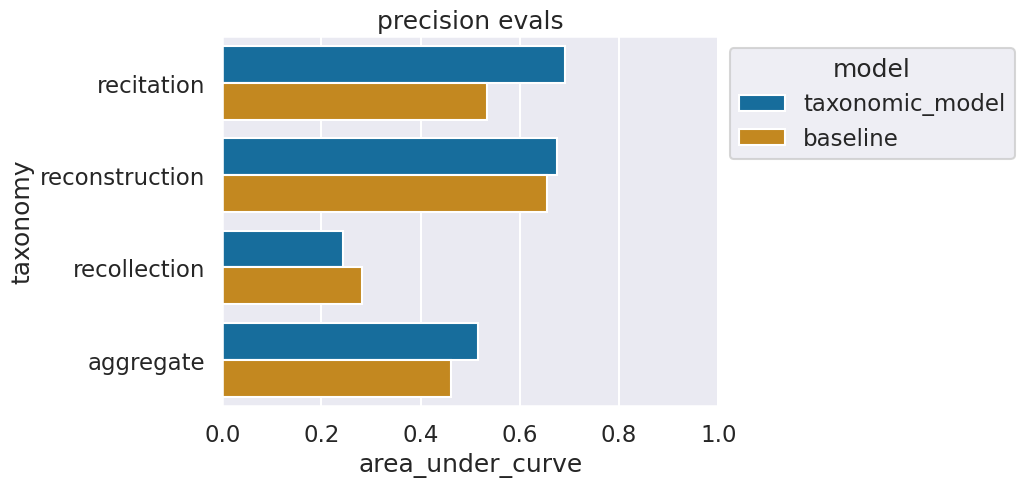

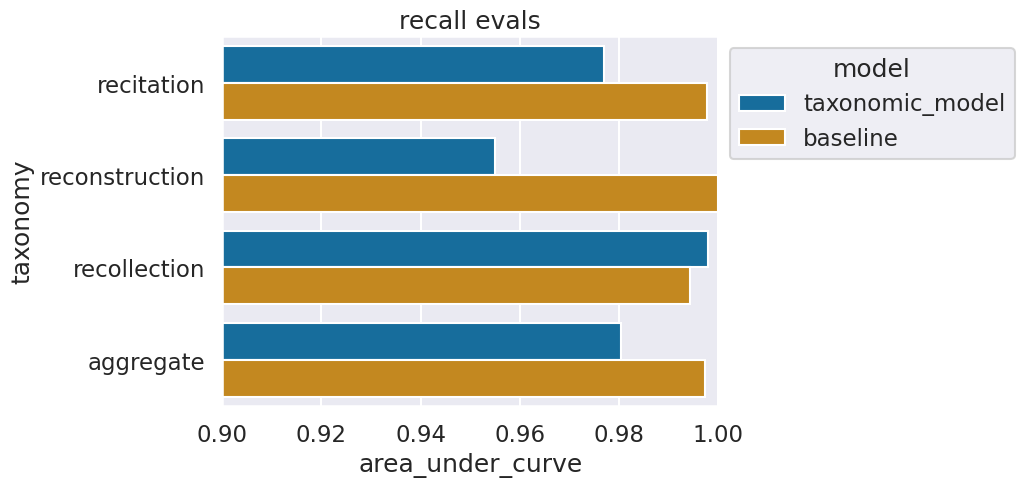

In [19]:
plot_taxonomy(base_evals_pd)

In [12]:
base_evals

,taxonomy,metric,value,model
0,recitation,roc,0.988724,taxonomic_model
1,recitation,pr,0.952931,taxonomic_model
2,recitation,precision,0.690965,taxonomic_model
3,recitation,recall,0.976943,taxonomic_model
4,recitation,roc,0.988204,baseline
5,recitation,pr,0.947308,baseline
6,recitation,precision,0.532812,baseline
7,recitation,recall,0.997810,baseline
8,reconstruction,roc,0.973088,taxonomic_model
9,reconstruction,pr,0.947085,taxonomic_model


In [4]:
TAXONOMIES = ['recitation', 'reconstruction', 'recollection']

In [5]:
base_taxonomy_evals = {
    'taxonomy': [],
    'roc_auc': [],
    'pr_auc': [],
    'split': [],
}
model_weights = {
    'taxonomy': [],
    'model_weights': [],
}
for taxonomy in TAXONOMIES:
    tax_path = os.path.join(baseline_path, taxonomy)
    with open(os.path.join(tax_path, 'metadata.json'), 'r') as f:
        metadata = json.load(f)
    
    with open(os.path.join(tax_path, 'lr.pkl'), 'rb') as f:
        model = pickle.load(f)
    model_weights['taxonomy'].append(taxonomy)
    model_weights['model_weights'].append(model.coef_[0].tolist())
    for (key, value) in metadata.items():
        if key.endswith('auc'):
            split, metric = "_".join(key.split('_')[:-2]), '_'.join(key.split('_')[-2:]) 
            if metric == 'roc_auc':
                base_taxonomy_evals['taxonomy'].append(taxonomy)
                base_taxonomy_evals['roc_auc'].append(value)
                base_taxonomy_evals['split'].append(split)
            else:
                base_taxonomy_evals['pr_auc'].append(value)
base_taxonomy_evals = pd.DataFrame.from_dict(base_taxonomy_evals)

In [6]:
base_taxonomy_evals

In [85]:
base_taxonomy_evals.to_csv("base_taxonomy_evals.csv")

In [86]:
sns.set_theme(style="darkgrid")
sns.set_palette("colorblind")
sns.set_context("talk")
def plot_taxonomy(taxonomy_evals, title=""):
    unwanted_splits = ['train', 'validation']
    taxonomy_evals = taxonomy_evals[taxonomy_evals['split'].map(lambda x:x not in unwanted_splits)]
    ax = sns.barplot(taxonomy_evals, y='roc_auc', x='taxonomy' , hue='split')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.ylabel('area_under_curve')
    plt.title(title + "roc_auc evals")
    plt.ylim(0.8, 1)
    plt.show()
    ax = sns.barplot(taxonomy_evals, y='pr_auc', x='taxonomy' , hue='split')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.title(title + "pr_auc evals")
    plt.ylabel('area_under_curve')
    plt.ylim(0.5, 1)
    plt.show()

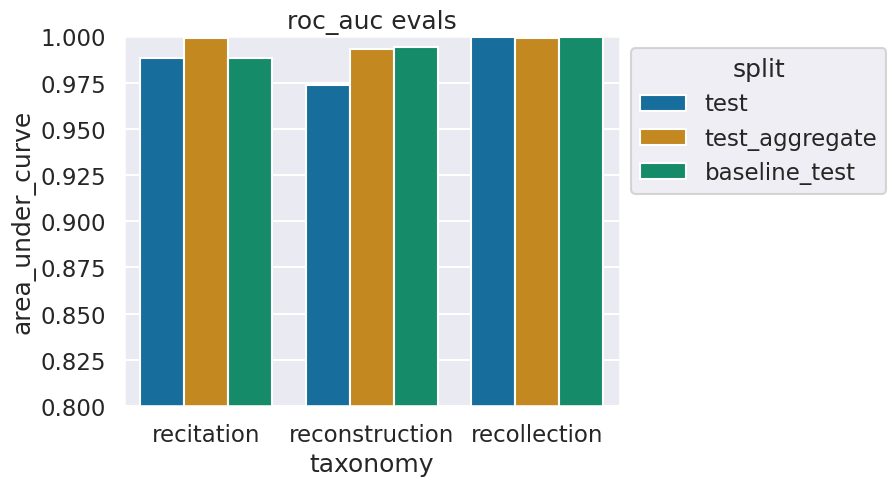

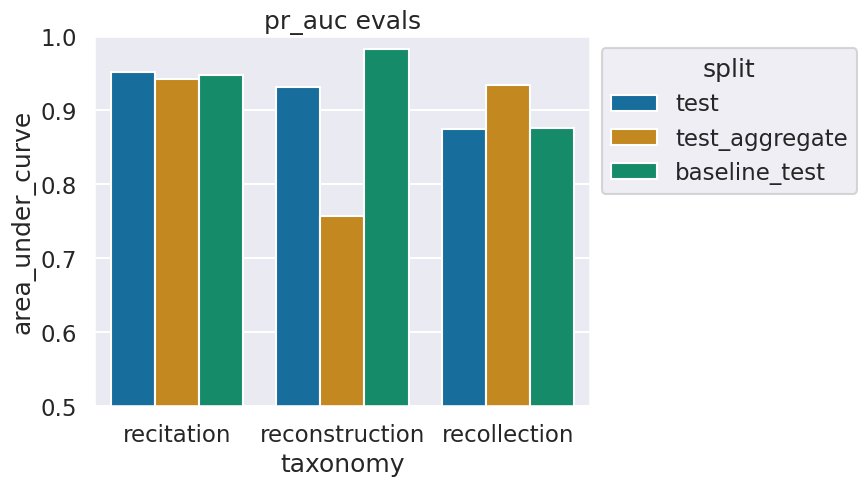

In [87]:
plot_taxonomy(base_taxonomy_evals)

# Finding optimal taxonomy

In [49]:
from tqdm.auto import tqdm
opt_taxonomy_evals = {
    'taxonomy_one_name': [],
    'taxonomy_one_threshold': [],
    'taxonomy_two_name': [],
    'taxonomy_two_threshold': [],
    'taxonomy': [],
    'metric': [],
    'value': [],
    'model': [],
}
for run in tqdm(os.listdir(RUN_PATH)):
    taxonomy_path = os.path.join(RUN_PATH, run, 'deduped', '12b', 'taxonomy_search')
    if not os.path.exists(taxonomy_path):
        continue
    for feature_one in os.listdir(taxonomy_path):
        for feature_two in os.listdir(os.path.join(taxonomy_path, feature_one)):
            meta_path = os.path.join(taxonomy_path, feature_one, feature_two, 'taxonomy_1', f'metadata.json')
            with open(meta_path, 'r') as f:
                metadata = json.load(f)
            f1, q1 = feature_one.split('-')
            q1 = float(q1)
            f2, q2 = feature_two.split('-')
            q2 = float(q2)
            print(f1, q1, f2, q2)
            data_path = os.path.join(taxonomy_path, feature_one, feature_two, 'taxonomic_prediction_metrics.json')
            with open(data_path, 'r') as f:
                data = json.load(f)
            for key, value in data.items():
                if key.endswith('pr_curve'):
                    continue
                model, taxonomy, metric, _ = key.split("_")
                if model == 'model':
                    model = 'optimal_taxonomic_model'
                opt_taxonomy_evals['taxonomy'].append(taxonomy)
                opt_taxonomy_evals['metric'].append(metric)
                opt_taxonomy_evals['value'].append(value)
                opt_taxonomy_evals['model'].append(model)
                opt_taxonomy_evals['taxonomy_one_name'].append(f1)
                opt_taxonomy_evals['taxonomy_one_threshold'].append(q1)
                opt_taxonomy_evals['taxonomy_two_name'].append(f2)
                opt_taxonomy_evals['taxonomy_two_threshold'].append(q2)
                
opt_taxonomy_evals = pd.DataFrame.from_dict(opt_taxonomy_evals)

  0%|          | 0/16 [00:00<?, ?it/s]

max_frequency 0.25 avg_frequency 0.5
max_frequency 0.25 avg_frequency 0.25
max_frequency 0.25 0_8_templates 0.75
max_frequency 0.25 huffman_coding_length 0.25
max_frequency 0.25 generation_perplexity 0.75
max_frequency 0.25 avg_frequency 0.75
max_frequency 0.25 huffman_coding_length 0.5
min_frequency 0.5 huffman_coding_length 0.75
min_frequency 0.5 avg_frequency 0.5
min_frequency 0.5 avg_frequency 0.25
min_frequency 0.5 0_8_templates 0.75
min_frequency 0.5 huffman_coding_length 0.25
min_frequency 0.5 generation_perplexity 0.75
min_frequency 0.5 max_frequency 0.25
min_frequency 0.5 max_frequency 0.75
min_frequency 0.5 avg_frequency 0.75
min_frequency 0.5 sequence_duplicates 0.25
min_frequency 0.5 median_frequency 0.25
min_frequency 0.5 median_frequency 0.5
min_frequency 0.5 median_frequency 0.75
min_frequency 0.5 max_frequency 0.5
min_frequency 0.5 huffman_coding_length 0.5
min_frequency 0.25 huffman_coding_length 0.75
min_frequency 0.25 sequence_duplicates 0.5
min_frequency 0.25 avg_fr

In [50]:
opt_taxonomy_evals[
    (opt_taxonomy_evals['taxonomy_one_name'] == '0_8_templates') &
    (opt_taxonomy_evals['taxonomy_one_threshold'] == 0.75) &
    (opt_taxonomy_evals['taxonomy_two_name'] == 'max_frequency') &
    (opt_taxonomy_evals['taxonomy_two_threshold'] == 0.5)
]

,taxonomy_one_name,taxonomy_one_threshold,taxonomy_two_name,taxonomy_two_threshold,taxonomy,metric,value,model
10016,0_8_templates,0.75,max_frequency,0.5,recitation,roc,0.977249,optimal_taxonomic_model
10017,0_8_templates,0.75,max_frequency,0.5,recitation,pr,0.900945,optimal_taxonomic_model
10018,0_8_templates,0.75,max_frequency,0.5,recitation,precision,0.532129,optimal_taxonomic_model
10019,0_8_templates,0.75,max_frequency,0.5,recitation,recall,0.998617,optimal_taxonomic_model
10020,0_8_templates,0.75,max_frequency,0.5,recitation,roc,0.988204,baseline
10021,0_8_templates,0.75,max_frequency,0.5,recitation,pr,0.947308,baseline
10022,0_8_templates,0.75,max_frequency,0.5,recitation,precision,0.532812,baseline
10023,0_8_templates,0.75,max_frequency,0.5,recitation,recall,0.997810,baseline
10024,0_8_templates,0.75,max_frequency,0.5,reconstruction,roc,0.969814,optimal_taxonomic_model
10025,0_8_templates,0.75,max_frequency,0.5,reconstruction,pr,0.914334,optimal_taxonomic_model


In [47]:
len(opt_taxonomy_evals)

10048

In [29]:
def get_taxonomy(taxonomy):
    if taxonomy == 'taxonomic_model':
        return 'optimal_taxonomic_model'
    else:
        return taxonomy

In [38]:
opt_taxonomy_evals['taxonomy'] = opt_taxonomy_evals['taxonomy'].map(get_taxonomy)

In [51]:
opt_taxonomy_evals_test = opt_taxonomy_evals[opt_taxonomy_evals['taxonomy'] == 'aggregate']

In [52]:
opt_taxonomy_evals_test.head(10)

,taxonomy_one_name,taxonomy_one_threshold,taxonomy_two_name,taxonomy_two_threshold,taxonomy,metric,value,model
24,max_frequency,0.25,avg_frequency,0.50,aggregate,roc,0.999183,optimal_taxonomic_model
25,max_frequency,0.25,avg_frequency,0.50,aggregate,pr,0.927930,optimal_taxonomic_model
26,max_frequency,0.25,avg_frequency,0.50,aggregate,precision,0.457496,optimal_taxonomic_model
27,max_frequency,0.25,avg_frequency,0.50,aggregate,recall,0.997222,optimal_taxonomic_model
28,max_frequency,0.25,avg_frequency,0.50,aggregate,roc,0.999261,baseline
29,max_frequency,0.25,avg_frequency,0.50,aggregate,pr,0.938144,baseline
30,max_frequency,0.25,avg_frequency,0.50,aggregate,precision,0.460548,baseline
31,max_frequency,0.25,avg_frequency,0.50,aggregate,recall,0.997222,baseline
56,max_frequency,0.25,avg_frequency,0.25,aggregate,roc,0.999190,optimal_taxonomic_model
57,max_frequency,0.25,avg_frequency,0.25,aggregate,pr,0.928637,optimal_taxonomic_model


In [57]:
for metric in opt_taxonomy_evals_test['metric'].unique():
    data = opt_taxonomy_evals_test[
        (opt_taxonomy_evals_test['metric'] == metric)&
        (opt_taxonomy_evals_test['model'] == 'optimal_taxonomic_model')
    ].sort_values(by='value', ascending=False)
    print(data[['taxonomy_one_name', 'taxonomy_one_threshold', 'taxonomy_two_name', 'taxonomy_two_threshold', 'value', 'metric']].head(10))

     taxonomy_one_name  taxonomy_one_threshold      taxonomy_two_name  \
1240     min_frequency                    0.25  huffman_coding_length   
6904  median_frequency                    0.75          min_frequency   
1080     min_frequency                    0.25       median_frequency   
6840  median_frequency                    0.75          avg_frequency   
1112     min_frequency                    0.25       median_frequency   
8824     avg_frequency                    0.75       median_frequency   
952      min_frequency                    0.25          max_frequency   
792      min_frequency                    0.25          avg_frequency   
7736  median_frequency                    0.25          max_frequency   
1016     min_frequency                    0.25          avg_frequency   

      taxonomy_two_threshold     value metric  
1240                    0.50  0.999235    roc  
6904                    0.25  0.999233    roc  
1080                    0.25  0.999231    roc  
6840

In [73]:
def add_to_taxonomy_and_plot(f1, q1, f2, q2):
    data = opt_taxonomy_evals[
        (opt_taxonomy_evals['taxonomy_one_name'] == f1) &
        (opt_taxonomy_evals['taxonomy_two_name'] == f2) &
        (opt_taxonomy_evals['taxonomy_one_threshold'] == q1) &
        (opt_taxonomy_evals['taxonomy_two_threshold'] == q2)
    ]
    data = data[['taxonomy', 'metric', 'value', 'model']]
    data = data[data['model'] == 'optimal_taxonomic_model']
    opt_evals_pd = pd.concat([base_evals_pd, data])
    plot_taxonomy(opt_evals_pd, title=f"{f1}-{q1}  {f2}-{q2}\noptimal_")

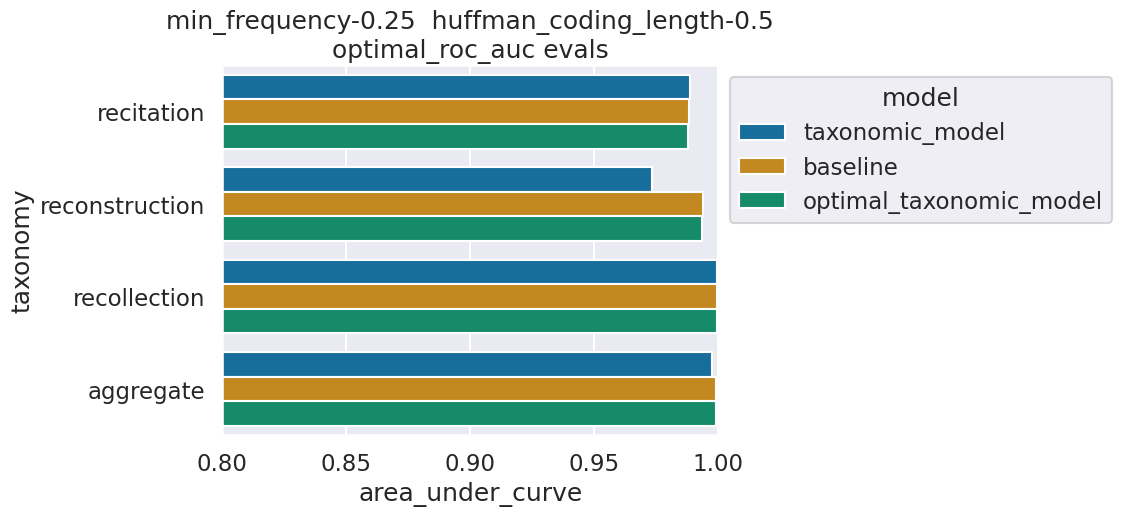

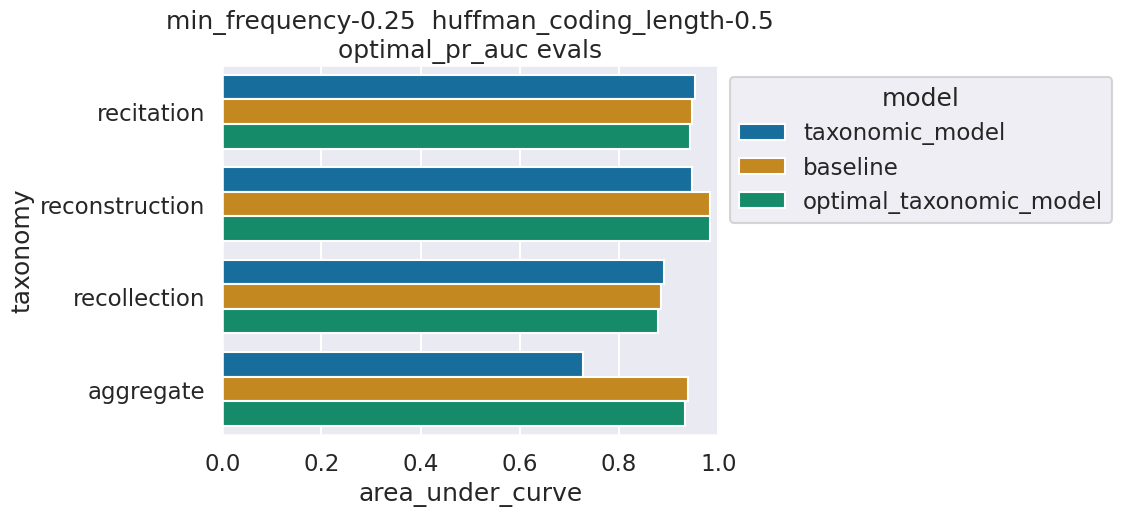

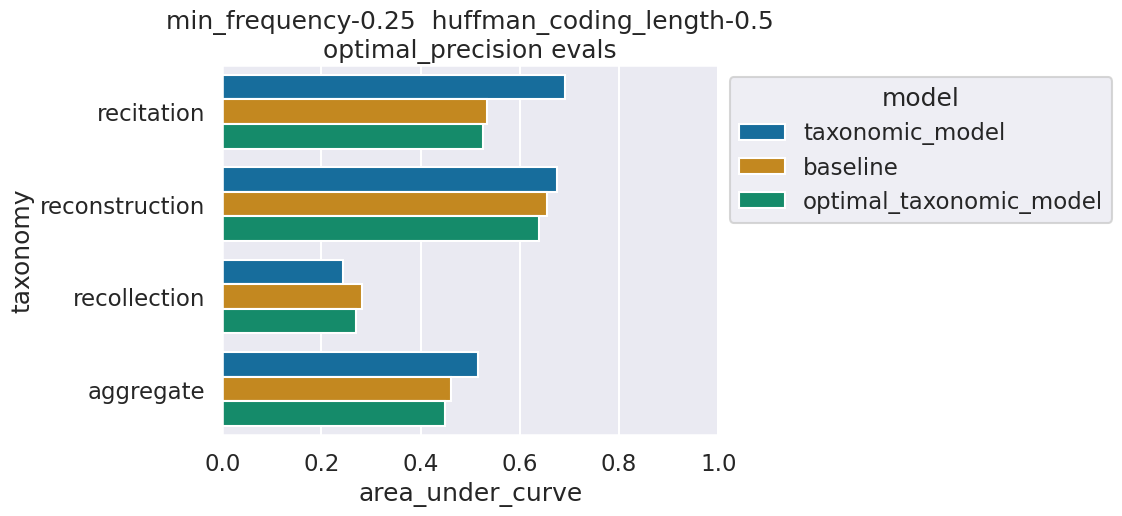

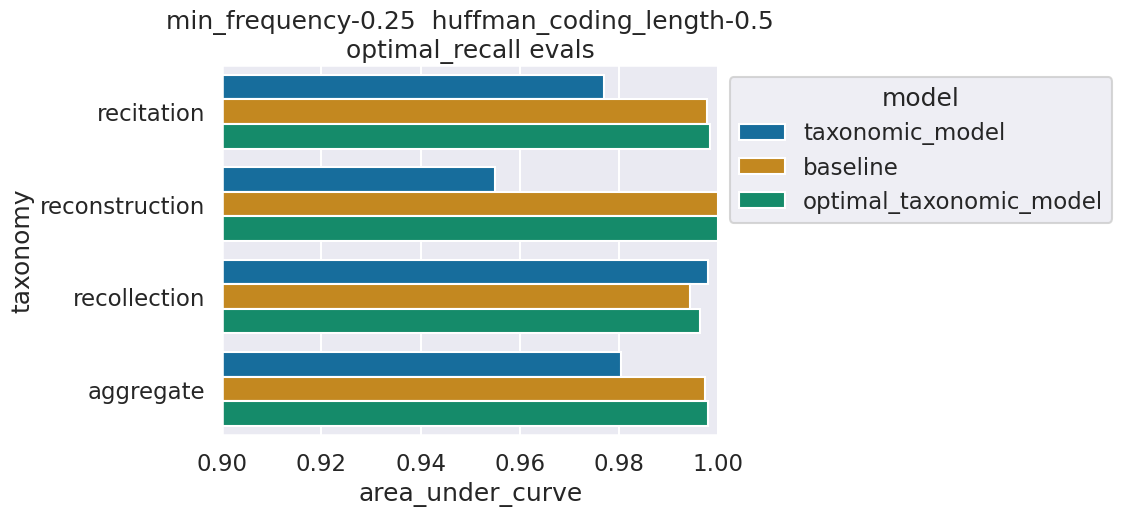

In [74]:
add_to_taxonomy_and_plot('min_frequency', 0.25, 'huffman_coding_length', 0.50)

In [89]:
taxonomy_evals_roc = {}
taxonomy_evals_pr = {}
for row in opt_taxonomy_evals_test.itertuples():
    row_tax = (row.taxonomy_one_name, row.taxonomy_one_threshold, 
               row.taxonomy_two_name, row.taxonomy_two_threshold)
    if row_tax in taxonomy_evals_roc:
        taxonomy_evals_roc[row_tax].append(row.roc_auc)
        taxonomy_evals_pr[row_tax].append(row.pr_auc)
    else:
        taxonomy_evals_roc[row_tax] = [row.roc_auc]
        taxonomy_evals_pr[row_tax] = [row.pr_auc]

# Shifting all single taxonomy evals into 0

In [91]:
all_keys = len(list(taxonomy_evals_roc.keys()))
erased_keys_roc = 0
erased_keys_pr = 0
erasable_keys = []
for key in taxonomy_evals_roc.keys():
    if len(taxonomy_evals_roc[key]) != 3:
        erased_keys_roc+=1
        erasable_keys.append(key)
    if len(taxonomy_evals_pr[key]) == 1:
        erased_keys_pr+=1

In [94]:
len(erasable_keys)

738

In [95]:
for key in erasable_keys:
    taxonomy_evals_roc.pop(key)
    taxonomy_evals_pr.pop(key)

In [41]:
erased_keys_roc

341

In [42]:
all_keys

809

In [96]:
import numpy as np
from pprint import pprint
taxonomy_evals_roc_mean = []
taxonomy_evals_pr_mean = []

for key in taxonomy_evals_roc:
    taxonomy_evals_roc_mean.append((np.mean(taxonomy_evals_roc[key]), key, taxonomy_evals_roc[key]))
    taxonomy_evals_pr_mean.append((np.mean(taxonomy_evals_pr[key]), key, taxonomy_evals_pr[key]))

taxonomy_evals_roc_mean.sort(reverse=True)
taxonomy_evals_pr_mean.sort(reverse=True)
pprint(taxonomy_evals_roc_mean[:10])
pprint(taxonomy_evals_pr_mean[:10])

[(0.9989873635169197,
  ('0_8_snowclones', 0.75, '0_8_templates', 0.5),
  [0.9990785566955479, 0.9987325874034244, 0.9991509464517868]),
 (0.9989873635169197,
  ('0_8_snowclones', 0.5, '0_8_templates', 0.5),
  [0.9990785566955479, 0.9987325874034244, 0.9991509464517868]),
 (0.9989873635169197,
  ('0_8_snowclones', 0.25, '0_8_templates', 0.5),
  [0.9990785566955479, 0.9987325874034244, 0.9991509464517868]),
 (0.9989761179285129,
  ('0_8_templates', 0.5, '0_8_snowclones', 0.75),
  [0.9990035252999202, 0.9987738820338317, 0.9991509464517868]),
 (0.9989761179285129,
  ('0_8_templates', 0.5, '0_8_snowclones', 0.5),
  [0.9990035252999202, 0.9987738820338317, 0.9991509464517868]),
 (0.9989761179285129,
  ('0_8_templates', 0.5, '0_8_snowclones', 0.25),
  [0.9990035252999202, 0.9987738820338317, 0.9991509464517868]),
 (0.9987398284229121,
  ('0_8_templates', 0.75, '0_8_snowclones', 0.75),
  [0.9979181924186192, 0.999075560453586, 0.9992257323965309]),
 (0.9987398284229121,
  ('0_8_templates', 0

In [ ]:
taxonomy_evals

In [16]:
opt_taxonomy_evals.to_csv("taxonomy_pairs.csv")

In [17]:
opt_taxonomy_evals['taxonomy'].value_counts()

taxonomy
taxonomy_3    4860
taxonomy_1    1620
taxonomy_2    1620
Name: count, dtype: int64

In [ ]:
len(does_not_exist)

In [ ]:
opt_taxonomy_evals_test = opt_taxonomy_evals[opt_taxonomy_evals['split'] == 'test_aggregate']

In [68]:
opt_taxonomy_evals_test.sort_values(['pr_auc', 'roc_auc'], ascending=False).head(50)

,taxonomy_one_name,taxonomy_one_threshold,taxonomy_two_name,taxonomy_two_threshold,roc_auc,pr_auc,split,taxonomy
482,max_frequency,0.25,sequence_duplicates,0.25,0.999251,0.938683,test_aggregate,taxonomy_3
596,min_frequency,0.25,sequence_duplicates,0.25,0.999251,0.938683,test_aggregate,taxonomy_3
626,avg_frequency,0.25,sequence_duplicates,0.25,0.999251,0.938683,test_aggregate,taxonomy_3
1412,sequence_duplicates,0.25,max_frequency,0.25,0.999251,0.938683,test_aggregate,taxonomy_3
1424,sequence_duplicates,0.25,median_frequency,0.75,0.999251,0.938683,test_aggregate,taxonomy_3
1436,sequence_duplicates,0.25,min_frequency,0.50,0.999251,0.938683,test_aggregate,taxonomy_3
1448,sequence_duplicates,0.25,median_frequency,0.25,0.999251,0.938683,test_aggregate,taxonomy_3
1460,sequence_duplicates,0.25,max_frequency,0.50,0.999251,0.938683,test_aggregate,taxonomy_3
1472,sequence_duplicates,0.25,median_frequency,0.50,0.999251,0.938683,test_aggregate,taxonomy_3
1484,sequence_duplicates,0.25,min_frequency,0.75,0.999251,0.938683,test_aggregate,taxonomy_3


In [67]:
def plot_best_taxonomy_cand(feature1, thresh1, feature2, thresh2):
    best_taxonomy_cand = opt_taxonomy_evals[
        (opt_taxonomy_evals['taxonomy_one_name'] == feature1) & 
        (opt_taxonomy_evals['taxonomy_two_name'] == feature2) & 
        (opt_taxonomy_evals['taxonomy_one_threshold'] == thresh1) & 
        (opt_taxonomy_evals['taxonomy_two_threshold'] == thresh2)
    ]
    plot_taxonomy(best_taxonomy_cand, title=f'{feature1} {thresh1}-{feature2}-{thresh2}\n')

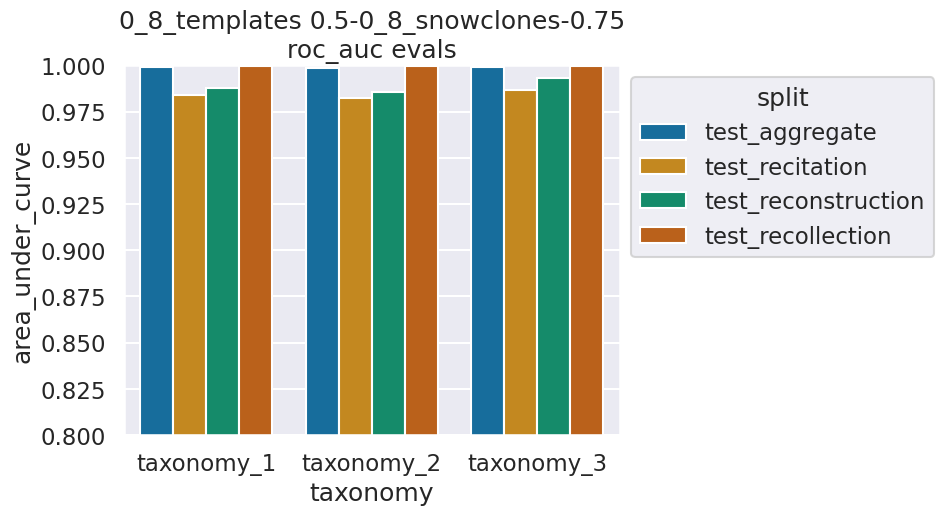

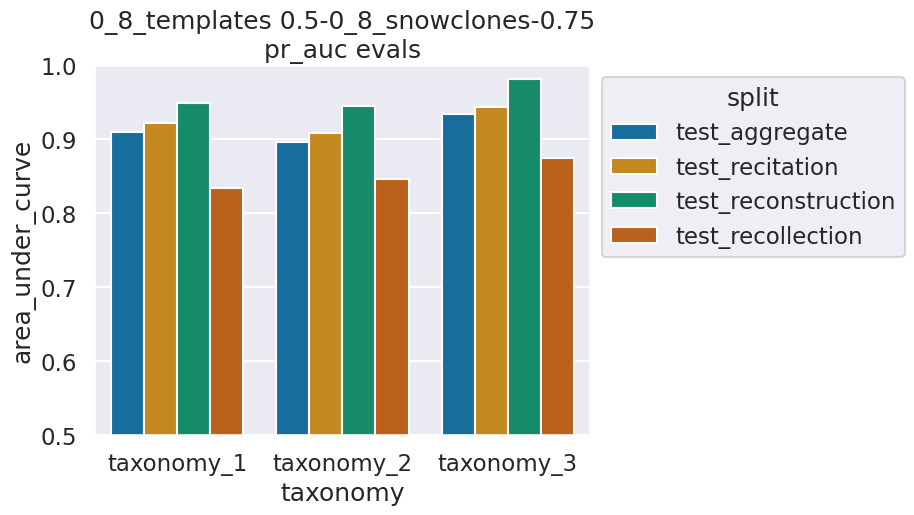

In [97]:
plot_best_taxonomy_cand('0_8_templates', 0.5, '0_8_snowclones', 0.75)

In [16]:
import pickle

In [37]:
baseline_model_path = os.path.join(baseline_path, 'recitation', 'lr.pkl')

In [38]:
with open(baseline_model_path, 'rb') as f:
    baseline_model = pickle.load(f)

In [19]:
import sys
sys.path.append("../")

In [20]:
from model_parameters import CONTINUOUS_FEATURE_COLUMNS, CATEGORICAL_FEATURE_COLUMNS

In [23]:
CONTINUOUS_FEATURE_COLUMNS

['sequence_duplicates',
 'max_frequency',
 'avg_frequency',
 'min_frequency',
 'median_frequency',
 'p25_frequency',
 'p75_frequency',
 'generation_perplexity',
 'prompt_perplexity',
 'sequence_perplexity',
 '0_8_templates',
 '0_8_snowclones',
 'huffman_coding_length']

In [24]:
import copy
all_feature_columns = copy.deepcopy(CONTINUOUS_FEATURE_COLUMNS)
all_feature_columns.extend(CATEGORICAL_FEATURE_COLUMNS)

In [25]:
all_feature_columns

['sequence_duplicates',
 'max_frequency',
 'avg_frequency',
 'min_frequency',
 'median_frequency',
 'p25_frequency',
 'p75_frequency',
 'generation_perplexity',
 'prompt_perplexity',
 'sequence_perplexity',
 '0_8_templates',
 '0_8_snowclones',
 'huffman_coding_length',
 'is_templating']

In [27]:
len(all_feature_columns)

14

In [40]:
len(baseline_model.coef_[0].tolist())

14

/weka/orz/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


[Text(0, 0, 'sequence_duplicates'),
 Text(1, 0, 'max_frequency'),
 Text(2, 0, 'avg_frequency'),
 Text(3, 0, 'min_frequency'),
 Text(4, 0, 'median_frequency'),
 Text(5, 0, 'p25_frequency'),
 Text(6, 0, 'p75_frequency'),
 Text(7, 0, 'generation_perplexity'),
 Text(8, 0, 'prompt_perplexity'),
 Text(9, 0, 'sequence_perplexity'),
 Text(10, 0, '0_8_templates'),
 Text(11, 0, '0_8_snowclones'),
 Text(12, 0, 'huffman_coding_length'),
 Text(13, 0, 'is_templating')]

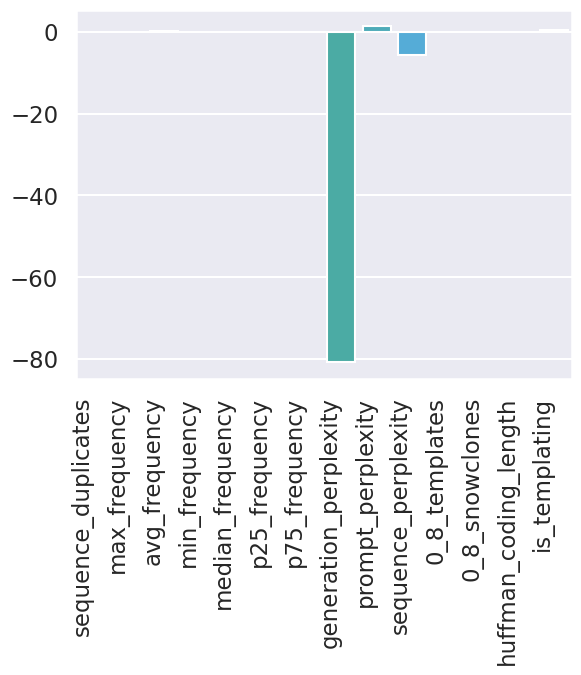

In [36]:
ax = sns.barplot(y=baseline_model.coef_[0].tolist(), x=all_feature_columns)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")